# LightGBM  for Crop Type and Land Classification
> Using LightGBM Classifier for crop type mapping for SERVIR Sat ML training. 

- toc: true
- badges: true
- author: Zhuang-Fang Yi, Drew Bollinger, Alex Mandel
- comments: false
- hide: true

This notebook teaches you to read satellite imagery (Sentinal-2) from Google Earth Engine and use it for crop type mapping with a [LightGBM](https://developmentseed.org/sat-ml-training/IntroMachineLearning#LightGBM) Classifier.

We will use data created by SERVIR East Africa, RCMRD, and FEWSNET. Demonstrating how to train a LightGBM classifier over Trans Nzoia county, Kenya.

>Note: If you would like to replicate the workflow with the same data on your local machine, please download the data from our shared [Google Drive folder](https://drive.google.com/drive/folders/1jM2mBsJ81QfmyaKZNeXSTyi_IOVr_3Vs?usp=sharing).

## Setup Notebook

In [1]:
#install python packages to run this notebook 
!pip install -q rasterio rasterstats geopandas treeinterpreter lightgbm

     |████████████████████████████████| 18.1MB 49.0MB/s 
     |████████████████████████████████| 972kB 46.2MB/s 
     |████████████████████████████████| 14.8MB 245kB/s 
     |████████████████████████████████| 133kB 45.3MB/s 
     |████████████████████████████████| 10.9MB 41.7MB/s 


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb

import rasterio
import rasterstats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import os
import pickle
from os import path as op

In [3]:
# Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Set a Google Drive directory as the default working directory
root_dir = "/content/drive/My Drive/Colab Notebooks/sat-ml-data"
# This is a Shared Drive with data copies (limited access)
shared_dir = "/content/drive/Shared drives/servir-sat-ml/data/"

# Make sure that folder exists
if (not op.isdir(root_dir)):
  os.mkdir(root_dir)


## Prepare Training Data

We will be using an already prepared training dataset that consists of polygons of each land use classification. These polygons were prepared by people using GIS digitizing methods (QGIS, ArcGIS, JOSM) with satellite imagery to trace over.

In [6]:
# read in training data
#training_vectors = gpd.read_file(op.join(root_dir, 'training_data.geojson'))
training_vectors = gpd.read_file(op.join(shared_dir, 'training_data.geojson'))
training_vectors.head()

,name,description,geometry
0,Shadow,None,"MULTIPOLYGON (((34.83383 1.18204, 34.83577 1.1..."
1,Forestland,None,"MULTIPOLYGON (((35.30961 1.01328, 35.30964 1.0..."
2,Maize,early reproductive,"MULTIPOLYGON (((34.90904 1.09515, 34.90907 1.0..."
3,Sugarcane,no change..maize farm on the right and far lef...,"MULTIPOLYGON (((34.90750 1.08934, 34.90753 1.0..."
4,Maize,reproductive good crop,"MULTIPOLYGON (((34.87144 0.82953, 34.87147 0.8..."


In [7]:
# find all unique values of training data names to use as classes
classes = np.unique(training_vectors.name)
# classes = np.array(sorted(training_vectors.name.unique()))
classes

array(['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland', 'Maize',
       'Shadow', 'Sugarcane', 'Sunflower', 'Waterbody'], dtype=object)

By assigning numeric ID to each class, we can will be able link results back to class names.

In [8]:
# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, range(len(classes))))
class_dict                  

{'Built': 0,
 'Cloud': 1,
 'Fallow': 2,
 'Forestland': 3,
 'Grassland': 4,
 'Maize': 5,
 'Shadow': 6,
 'Sugarcane': 7,
 'Sunflower': 8,
 'Waterbody': 9}

## Preparing Imagery

In this case like our [RandomForest](https://developmentseed.org/sat-ml-training/Randomforest_cropmapping-with_GEE#Reading-imagery-from-Google-Earth-Engine-(GEE)) example we will be using imagery exported from Google Earth Engine. Any source could used as long as you have data for the region of interest in a format the [GDAL](https://gdal.org/drivers/raster/index.html) library can read. [rasterio](https://rasterio.readthedocs.io/en/latest/) the python library for reading raster data builds on GDAL.

We highly recommend using [Cloud Optimized Geotiff (COG)](https://www.cogeo.org/#why) whenever possible to optimize the ability to due partial data reads from cloud stored data.

### Alternative Data Sources

Other data sources do exist for the same satellites. This includes cloud based sources like AWS Public Buckets, and SentinelHub. 

> Important: You can skip this section if you already have the data exported from the RandomForest lesson. Or access to the export we have but on Google Drive.

In [ ]:
# If not on Colab you'll need install the earth-engine Python API
#!pip install earthengine-api #earth-engine Python API

# Athenticate to your GEE account. 
!earthengine authenticate
# Earth Engine Python API
import ee 
ee.Initialize()

In [ ]:
# From GEE
#training_vectors.total_bounds.tolist()
aoi = ee.Geometry.Rectangle(training_vectors.total_bounds.tolist())
band_sel = ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')

sentinel_scenes = ee.ImageCollection("COPERNICUS/S2")\
    .filterBounds(aoi)\
    .filterDate('2019-05-02', '2019-05-03')\
    .select(band_sel)

scenes = sentinel_scenes.getInfo()
[print(scene['id']) for scene in scenes["features"]]

sentinel_mosaic = sentinel_scenes.mean().rename(band_sel)

In [ ]:
# We will save it to Google Drive for later reuse
raster_name = op.join(root_dir,'sentinel_mosaic-Trans_Nzoia')


In [ ]:
# Export the image, specifying scale and region.
# Warning, This specific export takes at least 1 hour, and 700+ MB
# GEE folder does not use a path, it uses a unique name to find the export location
task = ee.batch.Export.image.toDrive(**{
    'image': sentinel_mosaic,
    'description': 'Trans_nzoia_2019_05_02',
    'folder': op.basename(root_dir),
    'fileNamePrefix': raster_name,
    'scale': 10,
    'region': aoi,
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
      'cloudOptimized': 'true'
    },
})

# This task will run in the background even if you close this notebook.
# You can also check on the status of the task through the Javascript GEE interface
# https://code.earthengine.google.com
task.start()

## Model Training

### Preparing Data

First we will need to do some preparation to organize the training data into the correct python types, and to extract sample pixels from the intersecting imagery

In [10]:
%%time
# this larger cell reads data from a raster file for each training vector
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
# raster information
raster_file = op.join(shared_dir, 'Trans_nzoia_2019_05-02.tif')
bands = 6

# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.name, training_vectors.geometry):
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the (non-buffered) geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        # for each label pixel (places where the mask is true)...
        label_pixels = np.argwhere(mask)
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])

CPU times: user 15.1 s, sys: 1.61 s, total: 16.7 s
Wall time: 28.8 s


Now we need to put the data in arrays (numpy in this case), so that each row cell represents data, repeated over 6 bands (in this case columns). The shape property shows us the dimensions of the stored data.

In [11]:
# convert the training data lists into the appropriate shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((160461, 6), (160461,))

In addition to the raw pixel values we will calculated a couple of indices that help in some classifications.
* [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) - great for identiying photosynthesizing plants.
* [Normalized Difference Water Index (NDWI)](https://en.wikipedia.org/wiki/Normalized_difference_water_index) - great for identifying open water (when there isn't a lot of glare)

In [12]:
# (optional) add extra band indices

# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 3, 2)
ndwi = band_index(X, 1, 3)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape

(160461, 8)

Now were going to split 20% of the data to reserve for testing the quality of the trained model.

In [13]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since we don't have the same amount of training data for each class, we're going to calculate the relative quantities and tell the model so it can adjust to reduce bias.

In [14]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 0.00046882325363338024,
 1: 0.001597444089456869,
 2: 0.0004928536224741252,
 3: 1.970093973482535e-05,
 4: 0.000819000819000819,
 5: 1.5704257424187697e-05,
 6: 0.0002473410833539451,
 7: 0.0002824858757062147,
 8: 0.05263157894736842,
 9: 0.003115264797507788}

### Train LightGBM

In [15]:
%%time
# initialize a lightgbm

lgbm = lgb.LGBMClassifier(
       objective='multiclass',
       class_weight = class_weight_dict,
       num_class = len(class_dict),
       metric = 'multi_logloss')

CPU times: user 392 µs, sys: 0 ns, total: 392 µs
Wall time: 401 µs


In [16]:
# fit the model to the data (training)
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt',
               class_weight={0: 0.00046882325363338024, 1: 0.001597444089456869,
                             2: 0.0004928536224741252, 3: 1.970093973482535e-05,
                             4: 0.000819000819000819, 5: 1.5704257424187697e-05,
                             6: 0.0002473410833539451, 7: 0.0002824858757062147,
                             8: 0.05263157894736842, 9: 0.003115264797507788},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_class=10, num_leaves=31, objective='multiclass',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Assess the Model

Now we use the reserved test data to evaluate how well the model is able to predict.

In [17]:
# predict on X_test to evaluate the model
preds = lgbm.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)

And we can save a copy of the model for later resuse without the need to retrain.

In [18]:
model_name = 'light_gbm.sav'
pickle.dump(lgbm, open(op.join(root_dir, model_name), 'wb'))


### Confusion Matrix

A confusion matrix shows a comparision between what the class is based on the test data, and what the model predicted it to be. Low numbers are good. The diagonal from top left to bottom right, is a class compared to itself should be high. Values range from 0 to 1.

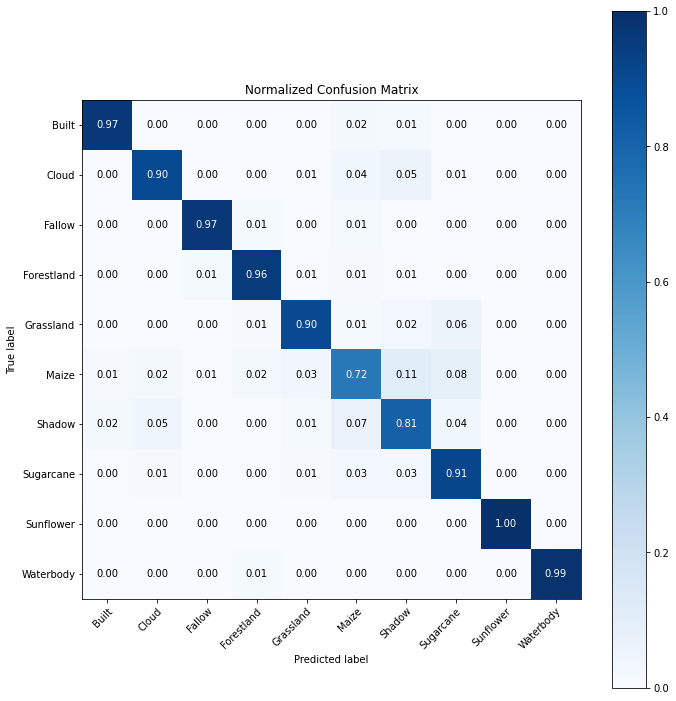

In [19]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

## Generate predictions over the full image


### Load the model

We can load the model we saved previously, so that we don't have to do all the work in the same session.

In [20]:
# if you want to use the pretrained model for new imagery

# match the pretrained model weight with the saved model above
model_name = 'light_gbm.sav'

# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)
  
lgbm = pickle.load(open(op.join(root_dir, model_name), 'rb'))

In [21]:
lgbm

LGBMClassifier(boosting_type='gbdt',
               class_weight={0: 0.00046882325363338024, 1: 0.001597444089456869,
                             2: 0.0004928536224741252, 3: 1.970093973482535e-05,
                             4: 0.000819000819000819, 5: 1.5704257424187697e-05,
                             6: 0.0002473410833539451, 7: 0.0002824858757062147,
                             8: 0.05263157894736842, 9: 0.003115264797507788},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_class=10, num_leaves=31, objective='multiclass',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Run the model on whole area

Now that we've trained and tested the model over the existing data we can use the trained LightGBM classifier `lgbm` over a whole satellite image that covers a larger geospatial location. We can split the job into small tiles to optimize the compute power and potentially do the classification in parallel.

In [22]:
%%time
# open connections to our input and output images

# new_image = op.join(root_dir, 'Trans_nzoia_2019_10-04.tif')
new_image = raster_file
output_image = op.join(root_dir, "lgbm_classification.tif")

with rasterio.open(new_image, 'r') as src:
  profile = src.profile
  profile.update(
      dtype=rasterio.uint8,
      count=1,
  )

  with rasterio.open(output_image, 'w', **profile) as dst: 

    # perform prediction on each small image patch to minimize required memory
    patch_size = 500

    for i in range((src.shape[0] // patch_size) + 1):
        for j in range((src.shape[1] // patch_size) + 1):
            # define the pixels to read (and write)
            window = rasterio.windows.Window(
                j * patch_size,
                i * patch_size,
                # don't read past the image bounds
                min(patch_size, src.shape[1] - j * patch_size),
                min(patch_size, src.shape[0] - i * patch_size)
            )
            
            data = src.read(window=window)
            # read the image into the proper format, adding indices if necessary
            img_swp = np.moveaxis(data, 0, 2)
            img_flat = img_swp.reshape(-1, img_swp.shape[-1])

            img_ndvi = band_index(img_flat, 3, 2)
            img_ndwi = band_index(img_flat, 1, 3)

            img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)

            # remove no data values, store the indices for later use
            # a later cell makes the assumption that all bands have identical no-data value arrangements
            m = np.ma.masked_invalid(img_w_ind)
            to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])
            
            # predict
            if not len(to_predict):
                continue
            img_preds = lgbm.predict(to_predict)
            
            # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
            # resize to the original image dimensions
            output = np.zeros(img_flat.shape[0])
            output[~m.mask[:,0]] = img_preds.flatten()
            output = output.reshape(*img_swp.shape[:-1])
            
            # create our final mask
            mask = (~m.mask[:,0]).reshape(*img_swp.shape[:-1])

            # write to the final file
            dst.write(output.astype(rasterio.uint8), 1, window=window)
            dst.write_mask(mask, window=window)
            # write to the final file
            dst.write(output.astype(rasterio.uint8), 1, window=window)
            dst.write_mask(mask, window=window)

### Explore the Results

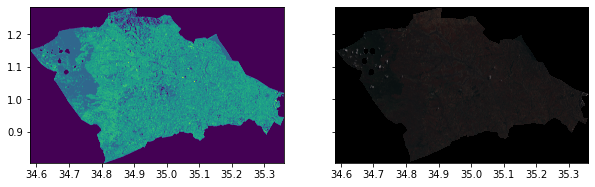

In [25]:
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline


# Load the classification
if os.path.exists(op.join(root_dir, "lgbm_classification.tif")):
  output_image = op.join(root_dir, "lgbm_classification.tif")
else:
  output_image = '/content/drive/Shared drives/servir-sat-ml/data/lgbm_classification.tif'


def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()


# Load the original image
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([1,2,3])

# Compare side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1, title="lgbm Classes")
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2, title="Sentinel 2 RGB")

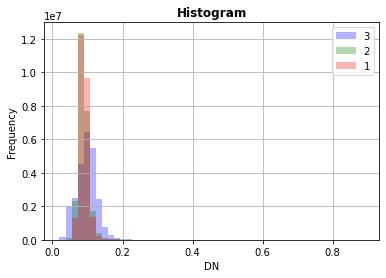

In [26]:
# The satellite image is really dark, lets see why
rasterio.plot.show_hist(s2, 
                   bins=50, 
                   histtype='stepfilled',
                   lw=0.0, 
                   stacked=False, 
                   alpha=0.3)

In [28]:
# Based on the histogram we'll set a threshold and rescale the data for visualization
# The values used for in_range are going to depend on the datatype and range of your data
# If you got the data from GEE try in_range(0, 2500)
for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band], 
            in_range=(0, 0.25), 
            out_range=[0, 255]
        )
s2 = s2.astype(np.uint8)

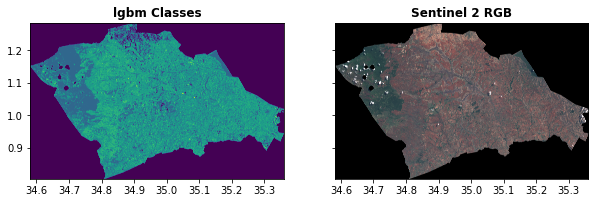

In [32]:
# Now retry the plot
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1, title="lgbm Classes")
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2, title="Sentinel 2 RGB")